In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[*********************100%***********************]  1 of 1 completed

Downloaded 8239 data points for SPY.


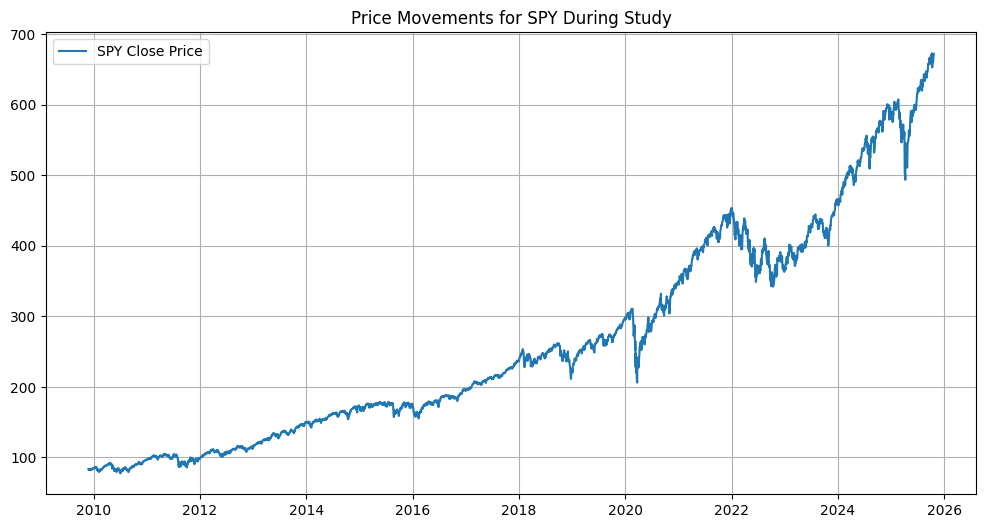

Step 1: Adding EMAs and ATR...
Step 2: Identifying Relaxed Trend Conditions...
Step 3: Identifying Pinbar Signals...
Step 4: Generating Final Entry Signals...
Step 5: Running the Backtest (with Stop-and-Reverse)...


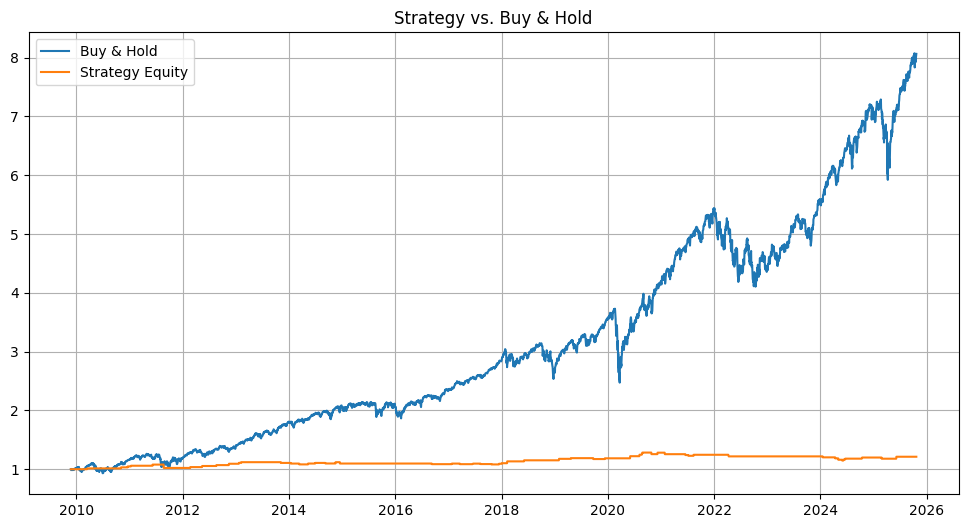


--- Backtest Results ---
Total Trades: 60
Strategy CAGR: 1.22%
Buy & Hold CAGR: 14.05%

--- Final DataFrame with Signals ---
Price            Close        High         Low        Open     Volume  \
Date                                                                    
2025-10-08  673.109985  673.210022  669.419983  670.250000   60702200   
2025-10-09  671.159973  673.940002  669.210022  673.530029   66501900   
2025-10-10  653.020020  673.950012  652.840027  672.130005  159422600   
2025-10-13  663.039978  665.130005  659.770020  660.650024   79560500   
2025-10-14  662.229980  665.830017  653.169983  657.169983   88779600   
2025-10-15  665.169983  670.229980  658.929993  666.820007   81702600   
2025-10-16  660.640015  668.710022  657.109985  666.820007  110563300   
2025-10-17  664.390015  665.760010  658.140015  659.500000   96500900   
2025-10-20  671.299988  672.210022  667.270020  667.320007   60409500   
2025-10-21  672.259888  672.989990  669.981018  671.440002   39635723  

In [27]:
# --- Global Settings ---
TICKER = 'SPY'
INTERVAL = '1d'
PERIOD = 'max'
LOOKBACK = 4000 # How many recent data points to use

# EMA Settings
EMA_FAST = 10
EMA_MEDIUM = 25
EMA_SLOW = 50

# ATR Settings for Stop Loss / Profit Target
ATR_LENGTH = 14
ATR_MULTIPLIER = 1.5


def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL, period=PERIOD):
    """Downloads and prepares the financial data."""
    df = yf.download(ticker, interval=interval, auto_adjust=True, period=period)
    print(f"Downloaded {len(df)} data points for {ticker}.")
    df.columns = df.columns.get_level_values(0)

    # Only return the subset of data you are interested in
    subset = df.iloc[-lookback:, :].copy()
    plt.figure(figsize=(12, 6))
    plt.plot(subset['Close'], label=f'{ticker} Close Price')
    plt.title(f'Price Movements for {ticker} During Study')
    plt.legend()
    plt.grid(True)
    plt.show()
    return subset

def add_indicators(df):
    """Step 1: Calculate all necessary technical indicators."""
    print("Step 1: Adding EMAs and ATR...")
    # Add EMAs
    df['EMA_Fast'] = df['Close'].ewm(span=EMA_FAST, adjust=False).mean()
    df['EMA_Medium'] = df['Close'].ewm(span=EMA_MEDIUM, adjust=False).mean()
    df['EMA_Slow'] = df['Close'].ewm(span=EMA_SLOW, adjust=False).mean()

    # Add ATR for risk management
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.ewm(span=ATR_LENGTH, adjust=False).mean()

    df.dropna(inplace=True)
    return df

def add_trend_conditions(df):
    """
    Step 2: Identify trend conditions based on relaxed EMA criteria.
    - Uptrend: Fast > Medium, Medium is sloping up, and no EMA is sloping down.
    - Downtrend: Fast < Medium, Medium is sloping down, and no EMA is sloping up.
    """
    print("Step 2: Identifying Relaxed Trend Conditions...")

    # --- Rule 1: The 2 EMAs in the 'Power of 2' (Fast/Medium) are in sequence ---
    uptrend_order = df['EMA_Fast'] > df['EMA_Medium']
    downtrend_order = df['EMA_Fast'] < df['EMA_Medium']

    # --- Rule 2: Slope Conditions ---
    
    # --- For Uptrend ---
    # Condition 2a: None of the 3 EMAs is sloping in the wrong direction (i.e., down)
    # This means they must be flat or sloping up (>=)
    no_down_slope = (df['EMA_Fast'] >= df['EMA_Fast'].shift(1)) & \
                    (df['EMA_Medium'] >= df['EMA_Medium'].shift(1)) & \
                    (df['EMA_Slow'] >= df['EMA_Slow'].shift(1))
    
    # Condition 2b: The longer-term EMA of the 'Power of 2' (Medium) is sloping in the right direction (i.e., strictly up)
    medium_slopes_up = df['EMA_Medium'] > df['EMA_Medium'].shift(1)
    
    # Combine uptrend slope rules
    uptrend_slope_criteria = no_down_slope & medium_slopes_up

    # --- For Downtrend ---
    # Condition 2a: None of the 3 EMAs is sloping in the wrong direction (i.e., up)
    # This means they must be flat or sloping down (<=)
    no_up_slope = (df['EMA_Fast'] <= df['EMA_Fast'].shift(1)) & \
                  (df['EMA_Medium'] <= df['EMA_Medium'].shift(1)) & \
                  (df['EMA_Slow'] <= df['EMA_Slow'].shift(1))
    
    # Condition 2b: The longer-term EMA (Medium) is sloping in the right direction (i.e., strictly down)
    medium_slopes_down = df['EMA_Medium'] < df['EMA_Medium'].shift(1)
    
    # Combine downtrend slope rules
    downtrend_slope_criteria = no_up_slope & medium_slopes_down

    # --- Final Trend Signal ---
    # We rename these to avoid confusion with the previous 'Strong_Uptrend'
    df['Trend_Up'] = uptrend_order & uptrend_slope_criteria
    df['Trend_Down'] = downtrend_order & downtrend_slope_criteria

    return df

def add_pinbar_signals(df):
    """Step 3: Identify Bullish and Bearish Pinbar-like patterns."""
    print("Step 3: Identifying Pinbar Signals...")
    
    # Calculate basic candle components
    body_size = np.abs(df['Close'] - df['Open'])
    candle_range = df['High'] - df['Low']

    # --- Correctly Define Wicks ---
    # Find the real body top and bottom
    body_top = df[['Open', 'Close']].max(axis=1)
    body_bottom = df[['Open', 'Close']].min(axis=1)
    
    # Upper wick is the range from the high to the top of the body
    upper_wick = df['High'] - body_top
    # Lower wick is the range from the bottom of the body to the low
    lower_wick = body_bottom - df['Low']

    # --- Bullish Pinbar (matches image) ---
    # 1. Long lower wick (at least 2x the body size)
    is_long_lower_wick = lower_wick > (body_size * 2)
    # 2. Small upper wick (less than half the body size)
    is_small_upper_wick = upper_wick < (body_size * 0.5)
    # 3. Body is in the upper third of the candle range
    is_body_in_upper_third = body_bottom > (df['High'] - (candle_range / 3))
    
    # Add a check to ensure the candle has some range and isn't a flat line
    has_range = candle_range > 0.0001 # Use a small number to avoid float issues

    df['Bullish_Pinbar'] = is_long_lower_wick & is_small_upper_wick & is_body_in_upper_third & has_range

    # --- Bearish Pinbar (matches image) ---
    # 1. Long upper wick (at least 2x the body size)
    is_long_upper_wick = upper_wick > (body_size * 2)
    # 2. Small lower wick (less than half the body size)
    is_small_lower_wick = lower_wick < (body_size * 0.5)
    # 3. Body is in the lower third of the candle range
    is_body_in_lower_third = body_top < (df['Low'] + (candle_range / 3))

    df['Bearish_Pinbar'] = is_long_upper_wick & is_small_lower_wick & is_body_in_lower_third & has_range

    return df


def add_entry_signals(df):
    """Step 4: Combine trend and pinbar signals to generate final trade entries."""
    print("Step 4: Generating Final Entry Signals...")
    # --- Buy Signal ---
    # Condition 1: Strong Uptrend is active
    # Condition 2: A Bullish Pinbar appeared
    # Condition 3: The close of the pinbar tested at least 2 EMAs for support
    supported_by_fast = df['Close'] >= df['EMA_Fast']
    supported_by_medium = df['Close'] >= df['EMA_Medium']
    supported_by_slow = df['Close'] >= df['EMA_Slow']
    # The .sum(axis=1) trick counts how many `True` values are in each row
    support_count = pd.concat([supported_by_fast, supported_by_medium, supported_by_slow], axis=1).sum(axis=1)
    is_supported = support_count >= 2

    df['Buy_Signal'] = df['Trend_Up'] & df['Bullish_Pinbar'] & is_supported
    
    # --- Sell Signal ---
    # Condition 1: Strong Downtrend is active
    # Condition 2: A Bearish Pinbar appeared
    # Condition 3: The close of the pinbar tested at least 2 EMAs for resistance
    rejected_by_fast = df['Close'] <= df['EMA_Fast']
    rejected_by_medium = df['Close'] <= df['EMA_Medium']
    rejected_by_slow = df['Close'] <= df['EMA_Slow']
    rejection_count = pd.concat([rejected_by_fast, rejected_by_medium, rejected_by_slow], axis=1).sum(axis=1)
    is_rejected = rejection_count >= 2

    df['Sell_Signal'] = df['Trend_Down'] & df['Bearish_Pinbar'] & is_rejected 

    return df

def run_backtest(df):
    """Step 5: Run the backtest with ATR-based risk management and Stop-and-Reverse."""
    print("Step 5: Running the Backtest (with Stop-and-Reverse)...")
    in_position = 0
    equity = [1] # Start with 1.0 for percentage-based returns
    stop_loss = 0
    profit_target = 0
    entry_price = 0

    for i in range(1, len(df)):
        # --- Check for SL/PT hit or Reversal Signal ---
        if in_position == 1: # Long position
            # 1a. Check for Stop Loss
            if df['Low'].iloc[i] <= stop_loss:
                in_position = 0
                trade_return = stop_loss / entry_price - 1
                equity.append(equity[-1] * (1 + trade_return))
                stop_loss, profit_target = 0, 0
                continue
            # 1b. Check for Profit Target
            elif df['High'].iloc[i] >= profit_target:
                in_position = 0
                trade_return = profit_target / entry_price - 1
                equity.append(equity[-1] * (1 + trade_return))
                stop_loss, profit_target = 0, 0
                continue
            
            # 1c. --- NEW: Check for opposing Sell Signal to reverse ---
            elif df['Sell_Signal'].iloc[i-1]:
                # First, close the long position (at the signal price)
                exit_price = df['Close'].iloc[i-1]
                trade_return = exit_price / entry_price - 1
                equity.append(equity[-1] * (1 + trade_return))
                
                # Second, enter the new short position
                in_position = -1
                entry_price = df['Close'].iloc[i-1]
                atr_value = df['ATR'].iloc[i-1]
                stop_loss = entry_price + (ATR_MULTIPLIER * atr_value)
                profit_target = entry_price - (ATR_MULTIPLIER * atr_value)
                continue # Action taken, move to next day

        elif in_position == -1: # Short position
            # 2a. Check for Stop Loss
            if df['High'].iloc[i] >= stop_loss:
                in_position = 0
                trade_return = 1 - stop_loss / entry_price
                equity.append(equity[-1] * (1 + trade_return))
                stop_loss, profit_target = 0, 0
                continue
            # 2b. Check for Profit Target
            elif df['Low'].iloc[i] <= profit_target:
                in_position = 0
                trade_return = 1 - profit_target / entry_price
                equity.append(equity[-1] * (1 + trade_return))
                stop_loss, profit_target = 0, 0
                continue
                
            # 2c. --- NEW: Check for opposing Buy Signal to reverse ---
            elif df['Buy_Signal'].iloc[i-1]:
                # First, close the short position
                exit_price = df['Close'].iloc[i-1]
                trade_return = 1 - exit_price / entry_price
                equity.append(equity[-1] * (1 + trade_return))
                
                # Second, enter the new long position
                in_position = 1
                entry_price = df['Close'].iloc[i-1]
                atr_value = df['ATR'].iloc[i-1]
                stop_loss = entry_price - (ATR_MULTIPLIER * atr_value)
                profit_target = entry_price + (ATR_MULTIPLIER * atr_value)
                continue # Action taken, move to next day
        
        # --- If not in position, check for a NEW entry signal ---
        # This block is now only checked if in_position was 0 at the start of the loop
        if in_position == 0:
            if df['Buy_Signal'].iloc[i-1]:
                in_position = 1
                entry_price = df['Close'].iloc[i-1]   
                atr_value = df['ATR'].iloc[i-1]     
                stop_loss = entry_price - (ATR_MULTIPLIER * atr_value)
                profit_target = entry_price + (ATR_MULTIPLIER * atr_value)

            elif df['Sell_Signal'].iloc[i-1]:
                in_position = -1
                entry_price = df['Close'].iloc[i-1]  
                atr_value = df['ATR'].iloc[i-1]     
                stop_loss = entry_price + (ATR_MULTIPLIER * atr_value)
                profit_target = entry_price - (ATR_MULTIPLIER * atr_value)
        
        # If no trade action, equity just holds from previous day
        if len(equity) < (i + 1):
             equity.append(equity[-1])

    # ... (rest of the function is identical) ...
    
    # Ensure equity series is same length as dataframe for plotting
    if len(equity) < len(df):
        equity.extend([equity[-1]] * (len(df) - len(equity)))
    
    df['Equity'] = equity
    df['Strategy_Returns'] = df['Equity'].pct_change()
    df['Buy_Hold_Returns'] = (df['Close'] / df['Close'].iloc[0])

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Buy_Hold_Returns'], label='Buy & Hold')
    plt.plot(df.index, df['Equity'], label='Strategy Equity')
    plt.title('Strategy vs. Buy & Hold')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Performance Metrics
    total_trades = (df['Buy_Signal'].shift(1).sum() + df['Sell_Signal'].shift(1).sum())
    strategy_cagr = (df['Equity'].iloc[-1]**(252/len(df)) - 1) * 100
    buy_hold_cagr = (df['Buy_Hold_Returns'].iloc[-1]**(252/len(df)) - 1) * 100

    print("\n--- Backtest Results ---")
    print(f"Total Trades: {total_trades}")
    print(f"Strategy CAGR: {strategy_cagr:.2f}%")
    print(f"Buy & Hold CAGR: {buy_hold_cagr:.2f}%")

    return df


# --- Run the main function ---
if __name__ == "__main__":
    results = main()
    # Display the tail of the dataframe with all the signals
    print("\n--- Final DataFrame with Signals ---")
    print(results.tail(10))

In [24]:
results_buy = results[results['Buy_Signal'] == True]
results_buy

date_range = results.loc['2018-01-26':'2018-02-26']

date_range



Price,Close,High,Low,Open,Volume,EMA_Fast,EMA_Medium,EMA_Slow,ATR,Trend_Up,Trend_Down,Bullish_Pinbar,Bearish_Pinbar,Buy_Signal,Sell_Signal,Equity,Strategy_Returns,Buy_Hold_Returns
Date,,,,,,,,,,,,,,,,,,
2018-01-26,58.971272,58.971272,58.001463,58.969783,42170000,57.502232,55.802143,54.146585,0.815280,True,False,True,False,True,False,0.856068,0.000000,4.050850
2018-01-29,58.917641,59.489695,58.797467,58.993120,31494000,57.759579,56.041797,54.333685,0.798873,True,False,False,False,False,False,0.856068,0.000000,4.047166
2018-01-30,58.465263,58.989647,58.323241,58.482645,37338000,57.887885,56.228217,54.495707,0.781210,True,False,False,False,False,False,0.856068,0.000000,4.016091
2018-01-31,58.706104,58.909702,58.203570,58.785058,36022000,58.036652,56.418824,54.660821,0.771200,True,False,False,False,False,False,0.856068,0.000000,4.032635
2018-02-01,58.674812,58.965808,58.067501,58.396731,73514000,58.152681,56.592361,54.818232,0.788148,True,False,False,False,False,False,0.856068,0.000000,4.030486
2018-02-02,55.576683,56.177538,55.177933,55.984867,117842000,57.684318,56.514232,54.847976,1.149312,False,False,False,False,False,False,0.838315,-0.020738,3.817669
2018-02-05,52.755638,55.367624,52.475076,54.653547,83550000,56.788194,56.225110,54.765923,1.409618,False,False,False,False,False,False,0.838315,0.000000,3.623886
2018-02-06,53.850090,53.996579,51.147728,51.344870,76630000,56.253994,56.042416,54.730008,1.601516,False,False,False,False,False,False,0.838315,0.000000,3.699066
2018-02-07,52.409027,53.954368,52.369796,53.876904,51942000,55.554909,55.762924,54.638989,1.599256,False,True,False,False,False,False,0.838315,0.000000,3.600077
